In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from tensorflow.python.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten

from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

2.9.1


C:\Users\pedro\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
##########################################################################
#Load data. We only need good data and anything NOT good is an outlier. 

image_directory = 'dataset/'
SIZE = 64
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  

good_images = os.listdir(image_directory + 'good/images/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'good/images/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))

dataset = np.array(dataset)

train = dataset[0:200]
test = dataset[200:279]

train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

In [3]:
#Let us also load bad images to verify our trained model. 
#bad_images = os.listdir(image_directory + 'bad')
#image_directory_anom = 'dataset/anomaly/'
bad_images = os.listdir(image_directory + 'bad/images/')
bad_dataset=[]
for i, image_name in enumerate(bad_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'bad/images/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        bad_dataset.append(np.array(image))
bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype('float32') / 255.

In [4]:
#########################################################################
#Define the encoder - decoder network for input to the OutlierVAE detector class. 
#Can be any encoder and decoder. 

encoding_dim = 1024  #Dimension of the bottleneck encoder vector. 
dense_dim = [8, 8, 512] #Dimension of the last conv. output. This is used to work our way back in the decoder. 

#from tensorflow.python.keras import Sequential
#Define encoder
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

##print(encoder_net.summary())
#print(encoder_net.input_shape)

In [5]:
#Define the decoder. 
#Start with the bottleneck dimension (encoder vector) and connect to dense layer 
#with dim = total nodes in the last conv. in the encoder. 
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

##print(decoder_net.summary())
#print(decoder_net.input_shape)

In [6]:
#######################################################################
#Define and train the outlier detector. 

latent_dim = 1024  #(Same as encoding dim. )

# initialize outlier detector
od = OutlierVAE(threshold=.015,  # threshold for outlier score above which the element is flagged as an outlier.
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=4)

print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.015


In [7]:
# train
#from alibi_detect.models.tensorflow.losses import elbo #evidence lower bound loss

adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train,
       optimizer = adam,
       epochs=300,
       batch_size=4,
       verbose=True)

#Check the threshold value. Should be the same as defined before. 
print("Current threshold value is: ", od.threshold)

C:\Users\pedro\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


50/50 [=] - 2s 32ms/step - loss_ma: -25135.2249
Current threshold value is:  0.015


In [8]:
#
#infer_threshold Updates threshold by a value inferred from the percentage of 
#instances considered to be outliers in a sample of the dataset.
#percentage of X considered to be normal based on the outlier score.
#Here, we set it to 99%
od.infer_threshold(test, outlier_type='instance', threshold_perc=99.0)
print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.002962614549323916


In [9]:
# save the trained outlier detector
#As mentioned in their documentation, save and load is having issues in python3.6 but works fine in 3.7
#from alibi_detect.utils import save_detector, load_detector  #If this does not work, try the next line
#from alibi_detect.utils.saving import save_detector, load_detector #Use this if the above line does not work. 
#save_detector(od, "saved_outlier_models/carpet_od_20epochs.h5")
#od = load_detector(filepath)

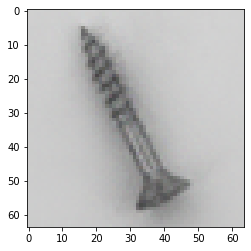

In [26]:
#Test our model on a bad image
img_num = 9
test_bad_image = bad_dataset[img_num].reshape(1, 64, 64, 3)
plt.imshow(test_bad_image[0])

test_bad_image_recon = od.vae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
plt.imshow(test_bad_image_recon[0])

test_bad_image_predict = od.predict(test_bad_image) #Returns a dictionary of data and metadata

The instance score is: 0.0011217408
Is this image an outlier (0 for NO and 1 for YES)? 0


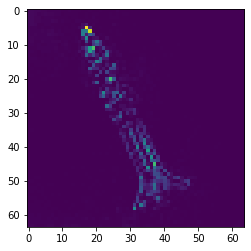

In [27]:
#Data dictionary contains the instance_score, feature_score, and whether it is an outlier or not. 
#Let u look at the values under the 'data' key in our output dictionary
bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
print("The instance score is:", bad_image_instance_score)

bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,0])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])

In [12]:
#You can also manually define the threshold based on your specific use case. 
od.threshold = 0.002
print("Current threshld value is: ", od.threshold)

Current threshld value is:  0.002


In [13]:
#Let us check it for multiple images
X = bad_dataset[:200]

od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

print(list(od_preds['data'].keys()))

['instance_score', 'feature_score', 'is_outlier']


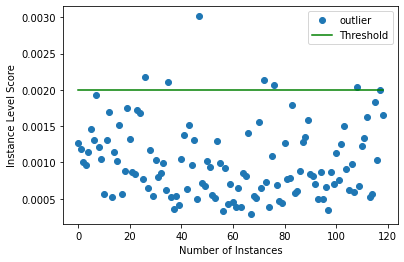

In [14]:
#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.ones(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

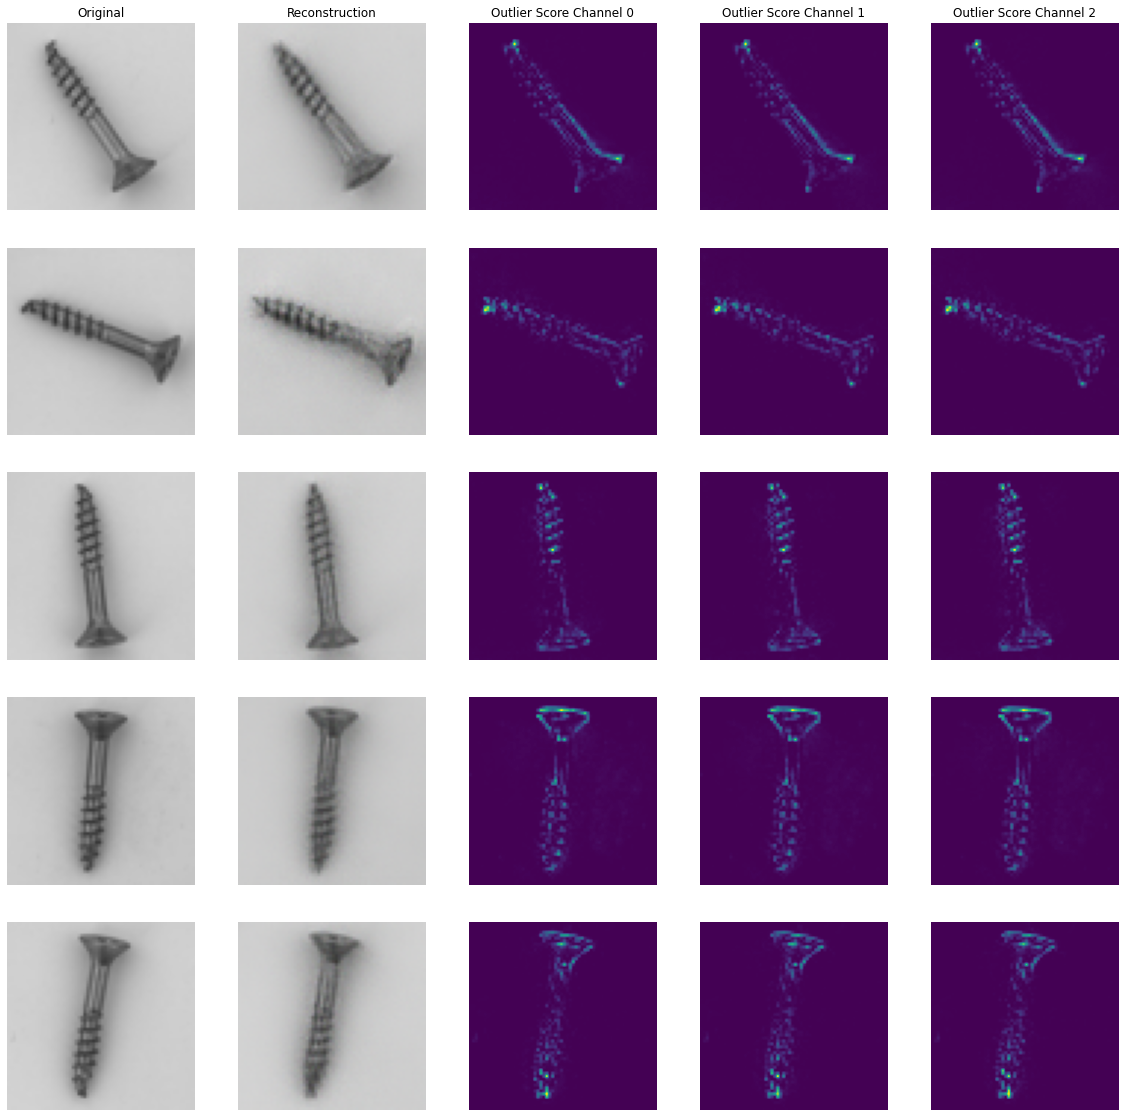

In [15]:
#Plot features for select images, using the built in function (plot_feature_outlier_image)
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[0, 5, 10, 15, 17],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions

#######################################